In [1]:
from torchsummary                 import summary
from tqdm                         import tqdm
from src.data.to_tensor           import ToTensor
from src.data.mrw_dataset         import MRWDataset
from src.data.create_data_loaders import create_data_loaders
from src.nn.archs                 import CNN_ALL, CNN_ALL_VDCNNFRW_M18
from src.nn.results.utils         import (get_all_predictions, analyse_predictions, 
                                            plot_distributions, plot_losses, get_MSEs, plot_correlation)

import random
import torch
import torch.nn           as nn
import numpy              as np
import src.ctes.num_ctes  as nctes
import src.ctes.str_ctes  as sctes
import src.ctes.path_ctes as pctes

In [2]:
builder = CNN_ALL

In [3]:
data_path = pctes.DATAPATH
timestamp = "2024_02_05__15_27_54"
arch_name = builder.__name__
hyperparams_path = f"../../../data/hyperparams_{arch_name}_{timestamp}.npz"
model_path = f"../../../data/model_{arch_name}_{timestamp}.pt"
losses_path = f"../../../data/losses_{arch_name}_{timestamp}.npz"
losses_img_path = f"../../../data/losses_{arch_name}_{timestamp}.png"

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device ' + str(device))

Using device cuda


In [5]:
hyperparams = np.load(hyperparams_path)
print(hyperparams)

NpzFile '../../../data/hyperparams_CNN_ALL_2024_02_05__15_27_54.npz' with keys: len, test_size, valid_size, epochs, batch_size...


In [6]:
seed = int(hyperparams[sctes.SEED])
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [7]:
sample_size = nctes.LEN_SAMPLE
model = builder(input_size=sample_size, dropout_probs=hyperparams[sctes.DROPOUT_PROBS])
model.to(device=device)
model.load_state_dict(torch.load(model_path, map_location=device))
summary(model, (1, sample_size))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 32767]          --
|    └─Conv1d: 2-1                       [-1, 128, 32767]          256
|    └─BatchNorm1d: 2-2                  [-1, 128, 32767]          256
|    └─ReLU: 2-3                         [-1, 128, 32767]          --
├─AvgPool1d: 1-2                         [-1, 128, 8192]           --
├─Sequential: 1-3                        [-1, 64, 8189]            --
|    └─Conv1d: 2-4                       [-1, 64, 8189]            32,768
|    └─BatchNorm1d: 2-5                  [-1, 64, 8189]            128
|    └─ReLU: 2-6                         [-1, 64, 8189]            --
├─AvgPool1d: 1-4                         [-1, 64, 2048]            --
├─Sequential: 1-5                        [-1, 32, 2041]            --
|    └─Conv1d: 2-7                       [-1, 32, 2041]            16,384
|    └─BatchNorm1d: 2-8                  [-1, 32, 2041]            64
|   

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 32767]          --
|    └─Conv1d: 2-1                       [-1, 128, 32767]          256
|    └─BatchNorm1d: 2-2                  [-1, 128, 32767]          256
|    └─ReLU: 2-3                         [-1, 128, 32767]          --
├─AvgPool1d: 1-2                         [-1, 128, 8192]           --
├─Sequential: 1-3                        [-1, 64, 8189]            --
|    └─Conv1d: 2-4                       [-1, 64, 8189]            32,768
|    └─BatchNorm1d: 2-5                  [-1, 64, 8189]            128
|    └─ReLU: 2-6                         [-1, 64, 8189]            --
├─AvgPool1d: 1-4                         [-1, 64, 2048]            --
├─Sequential: 1-5                        [-1, 32, 2041]            --
|    └─Conv1d: 2-7                       [-1, 32, 2041]            16,384
|    └─BatchNorm1d: 2-8                  [-1, 32, 2041]            64
|   

In [8]:
transform = ToTensor()

data      = MRWDataset(data_path, transform, sample_size, builder.LABELS)

In [9]:
batch_size = int(hyperparams[sctes.BATCH_SIZE])
valid_size = float(hyperparams[sctes.VALID_SIZE])
test_size = float(hyperparams[sctes.TEST_SIZE])

train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, test_size, data)

In [10]:
losses = np.load(losses_path)
train_losses = losses[sctes.TRAIN]
valid_losses = losses[sctes.VAL]

In [11]:
criterion = nn.MSELoss()
print(f"{criterion = }")

criterion = MSELoss()


In [12]:
data_len = int(hyperparams[sctes.LEN])
test_len = int(hyperparams[sctes.LEN]*hyperparams[sctes.TEST_SIZE])
valid_len = int((hyperparams[sctes.LEN] - hyperparams[sctes.LEN]*hyperparams[sctes.TEST_SIZE])*hyperparams[sctes.VALID_SIZE])
train_len = data_len - test_len - valid_len

if sctes.MODEL_NAME in hyperparams :
    print(f"Model name       = {hyperparams[sctes.MODEL_NAME]}")
print(f"Sample length    = {nctes.LEN_SAMPLE}")
print(f"Total samples    = {data_len}")
print(f"Train samples    = {train_len}")
print(f"Valid samples    = {valid_len}")
print(f"Test samples     = {test_len}")
print(f"Batch size       = {int(hyperparams[sctes.BATCH_SIZE])}")
print(f"Number of epochs = {int(hyperparams[sctes.EPOCHS])}")
print(f"Loss             = {''.join(hyperparams[sctes.CRITERION].tolist())}")
print(f"Optimizer        = {''.join(hyperparams[sctes.OPTIMIZER].tolist())}")
# print(f"Learning rate    = {float(hyperparams[sctes.LR])}")
print(f"Seed             = {float(hyperparams[sctes.SEED])}")
if sctes.DROPOUT_PROBS in hyperparams:
    print(f"Dropout probas    = {hyperparams[sctes.DROPOUT_PROBS].tolist()}")
print(f"Labels           = {builder.LABELS}")

Model name       = Top-Down v2
Sample length    = 32768
Total samples    = 12800
Train samples    = 8192
Valid samples    = 2048
Test samples     = 2560
Batch size       = 6
Number of epochs = 100
Loss             = MSELoss()
Optimizer        = Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0
)
Seed             = 42.0
Dropout probas    = []
Labels           = ['c1', 'c2', 'L', 'EPSILON']


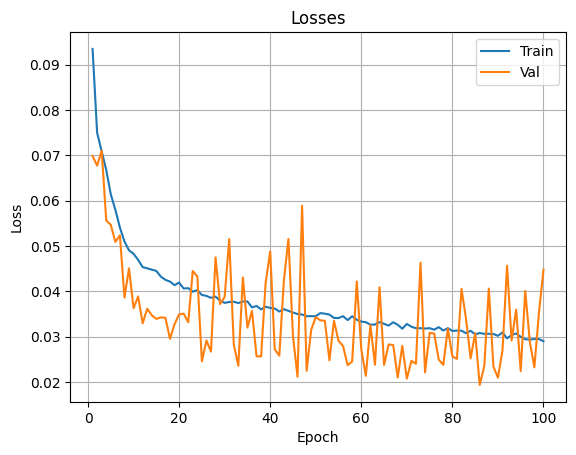

In [13]:
plot_losses(len(train_losses), [train_losses, valid_losses], ["Train", "Val"])
# plt.savefig(losses_img_path)

In [14]:
targets, preds, output_losses  = get_all_predictions(model, test_loader, device, criterion, builder.LABELS)

100%|██████████| 427/427 [00:02<00:00, 161.86it/s]


In [15]:
analyse_predictions(targets, preds)

True values of c1 and their count : 
0.0: 665 occurrences
0.3333333432674408: 625 occurrences
0.6666666865348816: 635 occurrences
1.0: 635 occurrences

Predicted values of c1 and their count: 
0.003910361789166927: 1 occurrences
0.006549380719661713: 1 occurrences
0.00727436225861311: 1 occurrences
0.007649931125342846: 1 occurrences
0.008252004161477089: 1 occurrences
0.00907477643340826: 1 occurrences
0.009689482860267162: 1 occurrences
0.009743762202560902: 1 occurrences
0.010389558039605618: 1 occurrences
0.010408683679997921: 1 occurrences
0.010494536720216274: 1 occurrences
0.01066653523594141: 1 occurrences
0.011213610880076885: 1 occurrences
0.011388123966753483: 1 occurrences
0.01153701264411211: 1 occurrences
0.011864189058542252: 1 occurrences
0.011911953799426556: 1 occurrences
0.012875487096607685: 1 occurrences
0.012973052449524403: 1 occurrences
0.012987392023205757: 1 occurrences
0.013369888998568058: 1 occurrences
0.013437471352517605: 1 occurrences
0.01359664462506771

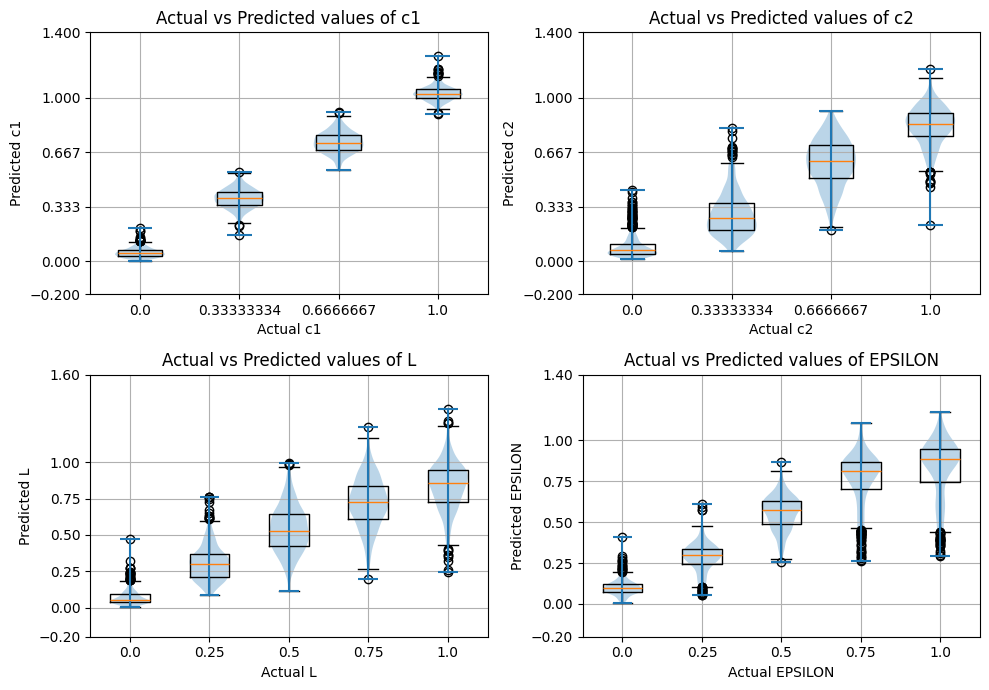

In [16]:
plot_distributions(targets, preds, builder.LABELS)

<Figure size 1000x700 with 0 Axes>

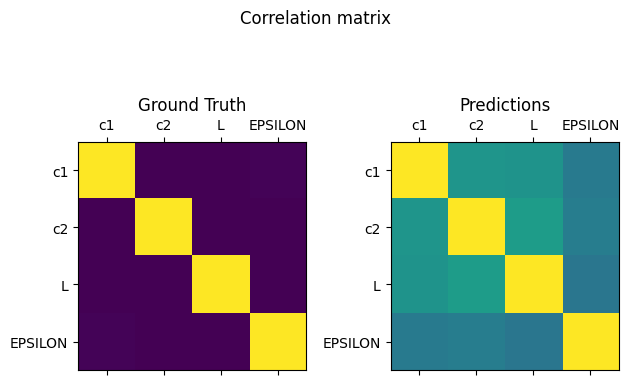

In [21]:
plot_correlation(targets, preds, builder.LABELS)

In [18]:
total_test_loss, mean_output_losses = get_MSEs(targets, preds, output_losses, builder.LABELS, device, criterion)
print("Total Test MSE = {:0.4f}".format(total_test_loss))
print("")
print("Test MSE for each output:")
for key, value in mean_output_losses.items():
    print(f"{key}: {value:.4f}")

Total Test MSE = 0.0208

Test MSE for each output:
c1: 0.0050
c2: 0.0251
L: 0.0278
EPSILON: 0.0253


In [19]:
n_show = 10
print(f"{n_show} Worst Results ==>")
for i in range(n_show):
    print(f"              c1         c2         L         epsilon")
    print(f"Target      = {['{:0.4f}'.format(f) for f in targets[i]]}")
    print(f"Prediction  = {['{:0.4f}'.format(f) for f in preds[i]]}")
    print(f"MSE         = {['{:0.4f}'.format(output_losses[p][i]) for p in range(len(builder.LABELS))]}")
    print()

10 Worst Results ==>
              c1         c2         L         epsilon
Target      = ['0.6667', '0.6667', '1.0000', '0.7500']
Prediction  = ['0.7776', '0.4390', '0.8939', '0.7730']
MSE         = ['0.0100', '0.0294', '0.1896', '0.0139']

              c1         c2         L         epsilon
Target      = ['0.3333', '0.0000', '0.5000', '0.2500']
Prediction  = ['0.4298', '0.0634', '0.6117', '0.3857']
MSE         = ['0.0097', '0.0173', '0.0561', '0.0109']

              c1         c2         L         epsilon
Target      = ['0.0000', '1.0000', '1.0000', '0.0000']
Prediction  = ['0.1326', '0.9740', '0.6674', '0.0782']
MSE         = ['0.0085', '0.0213', '0.0298', '0.0103']

              c1         c2         L         epsilon
Target      = ['0.0000', '0.0000', '1.0000', '0.7500']
Prediction  = ['0.0587', '0.0410', '0.3620', '0.8015']
MSE         = ['0.0024', '0.0277', '0.0287', '0.0216']

              c1         c2         L         epsilon
Target      = ['0.0000', '1.0000', '1.0000', 

In [20]:
n_show = 10
print(f"{n_show} Best Results ==>")
for i in range(n_show, 0, -1):
    print(f"              {[label + '    ' for label in builder.LABELS]}")
    print(f"Target      = {['{:0.4f}'.format(f) for f in targets[-i]]}")
    print(f"Prediction  = {['{:0.4f}'.format(f) for f in preds[-i]]}")
    print(f"MSE         = {['{:0.4f}'.format(output_losses[p][-i]) for p in range(len(builder.LABELS))]}")
    print()

10 Best Results ==>
              ['c1    ', 'c2    ', 'L    ', 'EPSILON    ']
Target      = ['0.6667', '0.0000', '0.0000', '0.5000']
Prediction  = ['0.5616', '0.0388', '0.1151', '0.8656']
MSE         = ['0.0174', '0.0511', '0.0232', '0.0080']

              ['c1    ', 'c2    ', 'L    ', 'EPSILON    ']
Target      = ['0.0000', '1.0000', '0.0000', '1.0000']
Prediction  = ['0.0880', '0.7040', '0.1339', '0.9053']
MSE         = ['0.0048', '0.0190', '0.0273', '0.0050']

              ['c1    ', 'c2    ', 'L    ', 'EPSILON    ']
Target      = ['0.3333', '1.0000', '0.5000', '0.2500']
Prediction  = ['0.4066', '0.9230', '0.9161', '0.3182']
MSE         = ['0.0020', '0.0615', '0.0103', '0.0187']

              ['c1    ', 'c2    ', 'L    ', 'EPSILON    ']
Target      = ['1.0000', '0.6667', '0.7500', '0.7500']
Prediction  = ['1.0897', '0.8606', '0.7757', '0.2927']
MSE         = ['0.0013', '0.0193', '0.0454', '0.0066']

              ['c1    ', 'c2    ', 'L    ', 'EPSILON    ']
Target      = ['0.333